In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neurokit2 as nk

from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from scipy.interpolate import interp1d

# Loading Data

In [13]:
SAMPLE_RATE = 100

In [14]:
df_all = pd.read_csv('ABPICP.csv', delimiter=';', decimal=',', names=['abp', 'icp'] )


# Predicting shape based on previous shape

In [15]:
df = df_all[['icp']].iloc[:5000]

In [16]:
train = df.iloc[:-90]
test = df.iloc[-90:]

# Predicting shape with standarisation of peak to peak points number

In [17]:
icp_signal = df_all['icp'].values
peaks = nk.ppg_findpeaks(icp_signal, sampling_rate=SAMPLE_RATE)['PPG_Peaks']

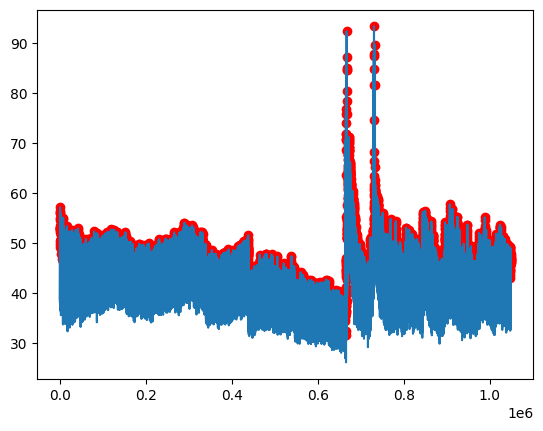

In [18]:
plt.plot(icp_signal)
plt.scatter(peaks, icp_signal[peaks], color='red')
plt.show()

In [19]:
peaks

array([    102,     184,     257, ..., 1048354, 1048427, 1048501])

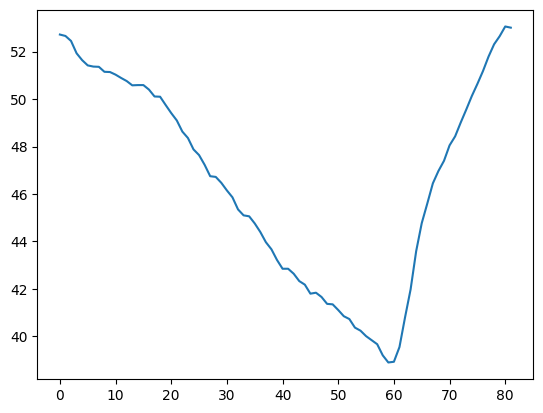

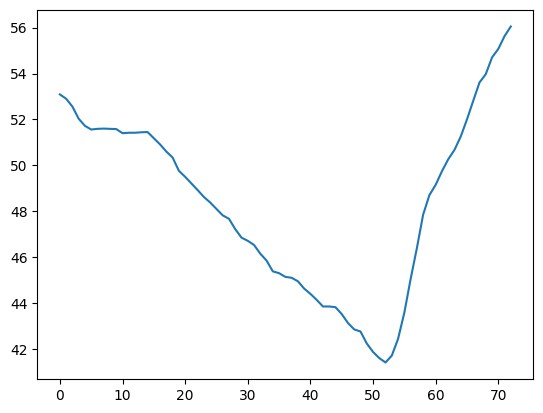

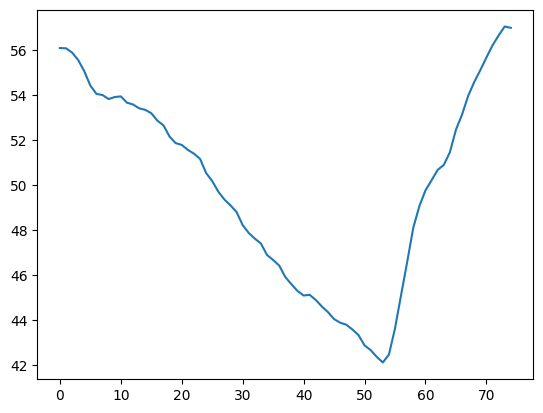

In [20]:
# divid my dataset to peak to peak segments
segments = []
for i in range(len(peaks)-1):
    segment = icp_signal[peaks[i]:peaks[i+1]]
    segments.append(segment)
    if i<3:
        plt.plot(segment)
        plt.show()

In [21]:
def standardize_segment(y: np.array) -> np.array:
    x = np.arange(len(y))
    f = interp1d(x, y)
    x_new = np.linspace(0, len(y)-1, 100)
    y_new = f(x_new)
    return y_new

In [22]:
standaralized_segments = [standardize_segment(segment) for segment in segments]

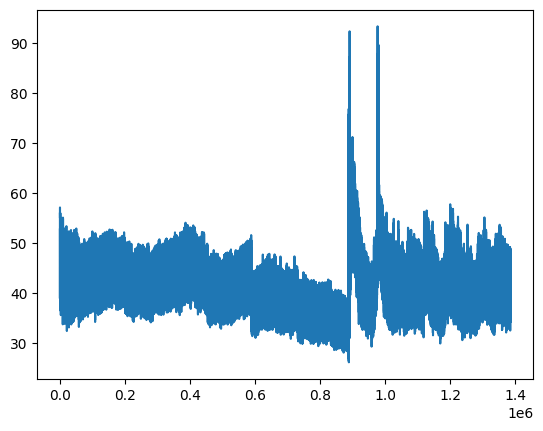

In [23]:
# conect the standaralized segments
merged_segments = np.concatenate(standaralized_segments)
plt.plot(merged_segments)

In [24]:
standaralized_df = pd.DataFrame(merged_segments, columns=['icp'])
standaralized_df

,icp
0,52.720000
1,52.670909
2,52.526364
3,52.213636
4,51.850909
...,...
1386195,45.566162
1386196,45.802121
1386197,45.854242
1386198,45.861010


In [25]:
train = standaralized_df.iloc[:-100]
test = standaralized_df.iloc[-100:]

In [26]:
df_comp = test['icp'].to_frame()
df_comp.reset_index(drop=True, inplace=True)
df_comp

,icp
0,46.890000
1,46.742525
2,46.542828
3,46.269697
4,45.886263
...,...
95,45.566162
96,45.802121
97,45.854242
98,45.861010


## XGBoost

In [27]:
data = standaralized_df.copy()

In [28]:
for i in range(100,0,-1):
  data['t='+str(i)] = data['icp'].shift(i)
data.dropna(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_3756\1098537540.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['t='+str(i)] = data['icp'].shift(i)


In [29]:
data

,icp,t=100,t=99,t=98,t=97,t=96,t=95,t=94,t=93,t=92,...,t=10,t=9,t=8,t=7,t=6,t=5,t=4,t=3,t=2,t=1
100,53.090000,52.720000,52.670909,52.526364,52.213636,51.850909,51.620000,51.440000,51.383636,51.364545,...,49.922727,50.361818,50.787273,51.235455,51.734545,52.168182,52.495455,52.799091,53.050909,53.010000
101,52.951818,52.670909,52.526364,52.213636,51.850909,51.620000,51.440000,51.383636,51.364545,51.283636,...,50.361818,50.787273,51.235455,51.734545,52.168182,52.495455,52.799091,53.050909,53.010000,53.090000
102,52.745455,52.526364,52.213636,51.850909,51.620000,51.440000,51.383636,51.364545,51.283636,51.148182,...,50.787273,51.235455,51.734545,52.168182,52.495455,52.799091,53.050909,53.010000,53.090000,52.951818
103,52.463636,52.213636,51.850909,51.620000,51.440000,51.383636,51.364545,51.283636,51.148182,51.140000,...,51.235455,51.734545,52.168182,52.495455,52.799091,53.050909,53.010000,53.090000,52.951818,52.745455
104,52.078182,51.850909,51.620000,51.440000,51.383636,51.364545,51.283636,51.148182,51.140000,51.050000,...,51.734545,52.168182,52.495455,52.799091,53.050909,53.010000,53.090000,52.951818,52.745455,52.463636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386195,45.566162,46.170000,46.570000,46.740909,46.778182,46.720000,46.890000,46.742525,46.542828,46.269697,...,43.248081,43.495253,43.652727,43.763333,44.099394,44.402727,44.625253,44.809596,44.976667,45.220303
1386196,45.802121,46.570000,46.740909,46.778182,46.720000,46.890000,46.742525,46.542828,46.269697,45.886263,...,43.495253,43.652727,43.763333,44.099394,44.402727,44.625253,44.809596,44.976667,45.220303,45.566162
1386197,45.854242,46.740909,46.778182,46.720000,46.890000,46.742525,46.542828,46.269697,45.886263,45.482222,...,43.652727,43.763333,44.099394,44.402727,44.625253,44.809596,44.976667,45.220303,45.566162,45.802121
1386198,45.861010,46.778182,46.720000,46.890000,46.742525,46.542828,46.269697,45.886263,45.482222,45.267576,...,43.763333,44.099394,44.402727,44.625253,44.809596,44.976667,45.220303,45.566162,45.802121,45.854242


In [30]:
X = data.iloc[:,1:].values
y = data.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
xgbr_grid = {
  'n_estimators': [50, 100, 200, 300, 400], 
  'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
  'learning_rate': [0.01, 0.02, 0.03],
  'random_state': [42], 
  }
best_score = -float('inf')

best_model = None

for g in ParameterGrid(xgbr_grid):
  model = XGBRegressor(**g)
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  if score > best_score:
    best_score = score
    best_model = model

train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

print('Error for train data:')
print(mean_absolute_percentage_error(y_train, train_predict) * 100)
print('Error for test data:')
print(mean_absolute_percentage_error(y_test, test_predict) * 100)

In [ ]:
def get_first_eval_batch(data, n):
  return data[-n:].reshape(-1,n)

In [ ]:
n_lag = 100
test_pred = []
current_batch = get_first_eval_batch(train['icp'].values, n_lag)
for i in range(len(test)):
  current_pred = best_model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

In [ ]:
df_comp['XGBoost'] = test_pred

<Axes: >

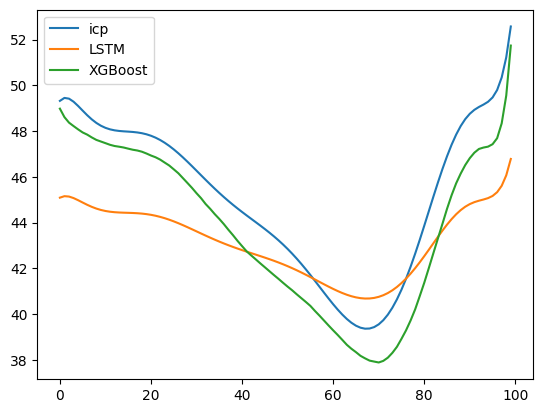

In [ ]:
df_comp.plot()